# Análise de Sentimento em Reviews do Olist
**Objetivo:**

O objetivo principal deste estudo é desenvolver um modelo de Análise de Sentimento capaz de classificar automaticamente as avaliações dos consumidores da plataforma Olist. O foco é identificar a polaridade da opinião expressa no texto do comentário, categorizando-a em duas classes principais:
- Satisfeito (Classe 1): Avaliações que apresentam experiências positivas, elogios e satisfação com o produto ou serviço (derivado de notas altas, como 4 e 5).
- Insatisfeito (Classe 0): Avaliações que indicam reclamações, problemas na entrega ou insatisfação com a compra (derivado de notas baixas, como 1, 2 e 3).

# 1. Configuração do Ambiente e Importação de Dependências


In [1]:
import sys
import os

path_do_script = '../../../src/T3/NLP'
sys.path.append(os.path.abspath(path_do_script))

In [25]:
import pandas as pd
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import nlp_utils
from nlp_utils import avaliar_modelo
from nlp_utils import nuvens_palavras
from nlp_utils import analisar_desbalanceamento
from nlp_utils import limpeza
from nlp_utils import stemming
from nlp_utils import resultados
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [3]:
# Descomentar antes de dar run pela primeira vez
# nltk.data.path.append(os.path.abspath("nltk_data"))
# nltk.download(['punkt', 'stopwords', 'rslp', 'punkt_tab'], quiet=True)

# 2. Carregamento e Engenharia de Atributos (Feature Engineering)
Nesta etapa, transformamos os dados brutos da Olist para o formato necessário para a modelagem:
- Seleção: Filtramos as colunas de texto (review_comment_message) e nota (review_score).
- Limpeza: Remoção de valores nulos (avaliações sem comentário).
- Binarização: Criação da variável alvo opinião:
    - 1 (Satisfeito): Notas 4 e 5.
    - 0 (Insatisfeito): Notas 1, 2 e 3.
    
**Objetivo:**
Simplificar o problema para um classificador binário de sentimentos, focando na distinção clara entre experiências positivas e negativas.

In [4]:
path = '../../../data/raw/'
reviews = pd.read_csv(f'{path}olist_order_reviews_dataset.csv')

In [5]:
# Criando uma nova tabela (dataframe) apenas com as colunas de interesse
df_nlp = reviews[['review_comment_message', 'review_score']].copy()
# Removendo as linhas onde não há comentários
df_nlp = df_nlp.dropna(subset=['review_comment_message'])

In [6]:
# Criando a nova coluna de sentimento
# Notas 4 e 5 viram 1 (Satisfeito)
# Notas 1, 2 e 3 viram 0 (Insatisfeito)
df_nlp['opinião'] = df_nlp['review_score'].apply(lambda x: 1 if x >= 4 else 0)
# Verificando nova distribuição
print(df_nlp['opinião'].value_counts())
# Removendo a coluna 'review_score'
df_nlp = df_nlp.drop('review_score', axis=1)
# Imprimindo a nova tabela
df_nlp.iloc[0]

opinião
1    26530
0    14447
Name: count, dtype: int64


review_comment_message    Recebi bem antes do prazo estipulado.
opinião                                                       1
Name: 3, dtype: object

### Avaliação do nível de desbalanceamento dos dados:

In [7]:
ir_valor = analisar_desbalanceamento(df_nlp, 'opinião')

--- Análise de Desbalanceamento ---
Imbalance Ratio (IR): 1.84
Classificação: Praticamente balanceado


# 3. Pipeline Básico
Nesta etapa, os comentários brutos passam por um fluxo de tratamento para reduzir a dimensionalidade e remover ruídos, preparando os dados para os modelos de classificação.


## 3.1 Limpeza (Cleaning)
Remoção de ruídos (pontuação, caracteres especiais) e padronização (caixa baixa).

In [8]:
df_nlp = limpeza(df_nlp, 'review_comment_message')
df_nlp.iloc[0]

review_comment_message    recebi bem antes do prazo estipulado
opinião                                                      1
Name: 3, dtype: object

## 3.2 Tokenização
Segmentação do texto bruto em unidades menores (tokens). Esta etapa transforma as frases em listas de palavras isoladas, permitindo o processamento individual de cada termo.

In [9]:
# Lógica de Tokenização Limpa
def tokenizar(texto):
    return nltk.word_tokenize(str(texto))
# Aplicação direta na tabela
df_nlp['review_comment_message'] = df_nlp['review_comment_message'].apply(tokenizar)
df_nlp.iloc[0]

review_comment_message    [recebi, bem, antes, do, prazo, estipulado]
opinião                                                             1
Name: 3, dtype: object

## 3.3 Filtragem (Stopwords):
Remoção de palavras frequentes que possuem alta frequência gramatical, mas baixo valor semântico (como "e", "de", "o"). Nesta etapa, também foram removidos termos específicos do domínio (anonimização de vendedores).

In [10]:
# Carregando as stopwords padrão do português
palavras_irrelevantes = set(stopwords.words('portuguese'))
# Lista de casas de GoT 
casas_got = {
    'lannister', 'stark', 'targaryen', 'baratheon', 'greyjoy', 
    'tyrell', 'martell', 'arryn', 'tully', 'mormont', 'karstark', 
    'bolton', 'frey', 'tarly', 'clegane', 'dondarrion', 'glover'
}
# Adicionando as casas à lista de remoção
palavras_irrelevantes.update(casas_got)
def remover_stopwords(lista_tokens):
    # Filtrando a lista e removendo o que for irrelevante
    return [p for p in lista_tokens if p not in palavras_irrelevantes]
# Aplicando a limpeza na coluna de mensagens já tokenizadas
df_nlp['review_comment_message'] = df_nlp['review_comment_message'].apply(remover_stopwords)
df_nlp.iloc[0] 

review_comment_message    [recebi, bem, antes, prazo, estipulado]
opinião                                                         1
Name: 3, dtype: object

## 3.4 Refinamento Léxico (Stemming) 
Aplicação do algoritmo RSLP (Removedor de Sufixos da Língua Portuguesa) para extrair o radical das palavras, consolidando variações gramaticais e reduzindo a dimensionalidade do vocabulário.

In [11]:
df_nlp = stemming(df_nlp, 'review_comment_message')
df_nlp.iloc[0]

review_comment_message    receb bem ant praz estipul
opinião                                            1
Name: 3, dtype: object

## 3.5 Divisão da Base de Dados (Holdout)
Divisão do conjunto de dados processados em subconjuntos de treino e teste. Esta técnica é usada para garantir que o modelo seja avaliado em dados que nunca viu, simulando o desempenho em produção.


In [12]:
# X é o nosso texto limpo com stemming, y é a opinião (0 ou 1)
X = df_nlp['review_comment_message']
y = df_nlp['opinião']
# Separando 20% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 3.6 Vetorização de Texto (Extração de Atributos)
Conversão do texto processado em representações numéricas (tensores) através das técnicas Bag of Words (CountVectorizer) e TF-IDF, preparando os dados para a entrada nos modelos de Machine Learning.

In [13]:
# --- CONFIGURAÇÃO BAG OF WORDS (BoW) ---
# Usando os hiperparâmetros
bow_vectorizer = CountVectorizer(
    ngram_range=(1, 2), 
    min_df=5,
    max_df=0.8,
    max_features=5000,
    binary=False
)
# --- CONFIGURAÇÃO TF-IDF ---
# Usando os hiperparâmetros
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    max_features=5000,
    sublinear_tf=True
)
# Aplicando nos dados de treino
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 4. Treinamento e Avaliação de Modelos
Nesta etapa, submetemos as matrizes de características (BoW e TF-IDF) a diferentes algoritmos de Aprendizado de Máquina. O objetivo é comparar o desempenho de modelos com diferentes abordagens matemáticas para o problema de classificação de sentimentos. Para cada modelo, analisamos a Precisão, o Recall e o F1-Score, com foco especial na capacidade do modelo de identificar corretamente os clientes Insatisfeitos, que representam o maior desafio estratégico para a Olist.

## 4.1 Multinomial Naive Bayes
Baseado no Teorema de Bayes, ele calcula a probabilidade de uma avaliação pertencer a uma classe (Satisfeito/Insatisfeito) com base na frequência das palavras.

**Conclusão:**

A análise comparativa demonstrou que o algoritmo Naive Bayes obteve um desempenho alto na classificação das avaliações da Olist. A técnica de vetorização TF-IDF apresentou a melhor performance, alcançando uma acurácia de 89% e um F1-Score superior para ambas as classes.


===== Naive Bayes + BoW =====
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      2890
           1       0.91      0.90      0.91      5306

    accuracy                           0.88      8196
   macro avg       0.87      0.87      0.87      8196
weighted avg       0.88      0.88      0.88      8196


===== Naive Bayes + TF-IDF =====
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2890
           1       0.91      0.91      0.91      5306

    accuracy                           0.89      8196
   macro avg       0.87      0.88      0.88      8196
weighted avg       0.89      0.89      0.89      8196



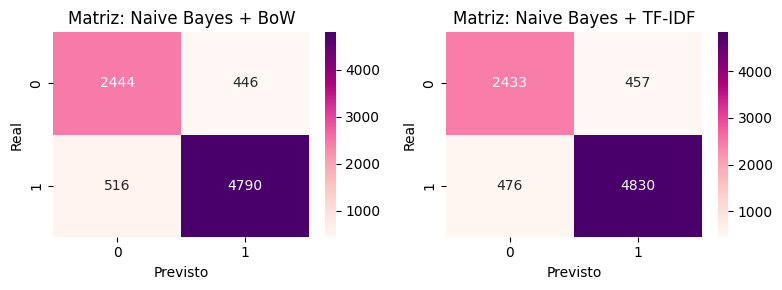

In [14]:
avaliar_modelo(MultinomialNB(), "Naive Bayes", 
               X_train_bow, X_test_bow, 
               X_train_tfidf, X_test_tfidf, 
               y_train, y_test)

# 4.2 Logistic Regression (Regressão Logística)
Utiliza uma função logística (sigmoide) para modelar a probabilidade de uma classe. Pode ser utilizada para encontrar relações lineares entre as palavras e o sentimento, como para classificação binária.

**Conclusão:**

O modelo de Regressão Logística consolidou os resultados positivos da etapa anterior, mantendo uma acurácia de 89%. Diferente do Naive Bayes, este algoritmo apresentou maior consistência entre as técnicas de vetorização. O Bag of Words (BoW) destacou-se por apresentar o menor índice de Falsos Negativos (391), sendo mais eficaz em reconhecer corretamente os elogios dos clientes. Já o TF-IDF mostrou-se superior na redução de Falsos Positivos (466), sendo mais conservador e preciso ao identificar críticas.


===== Logistic Regression + BoW =====
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      2890
           1       0.90      0.93      0.91      5306

    accuracy                           0.89      8196
   macro avg       0.88      0.87      0.88      8196
weighted avg       0.89      0.89      0.89      8196


===== Logistic Regression + TF-IDF =====
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2890
           1       0.91      0.92      0.92      5306

    accuracy                           0.89      8196
   macro avg       0.88      0.88      0.88      8196
weighted avg       0.89      0.89      0.89      8196



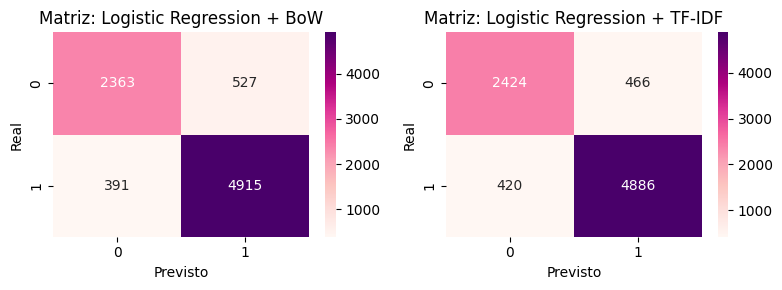

In [15]:
avaliar_modelo(LogisticRegression(max_iter=1000), "Logistic Regression", 
               X_train_bow, X_test_bow, 
               X_train_tfidf, X_test_tfidf, 
               y_train, y_test)

## 4.3 Linear SVC (Support Vector Machine)
Busca encontrar o "hiperplano" (uma linha de decisão) que maximize a margem de separação entre as classes. Em textos, onde temos milhares de dimensões (palavras), o SVM é eficaz em encontrar fronteiras de decisão complexas.

**Conclusão:**

O modelo Linear SVC apresentou um bom desempenho, atingindo uma acurácia de 88% com a vetorização TF-IDF. Assim como na Regressão Logística, este algoritmo demonstrou alta consistência no processamento do volume de dados. O Bag of Words (BoW) destacou-se por apresentar o menor índice de Falsos Negativos (460), sendo mais sensível para validar os elogios dos clientes. Já o TF-IDF mostrou-se superior na redução de Falsos Positivos (502), sendo mais rigoroso e preciso ao identificar as críticas.


===== Linear SVC + BoW =====
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      2890
           1       0.89      0.91      0.90      5306

    accuracy                           0.87      8196
   macro avg       0.86      0.85      0.86      8196
weighted avg       0.87      0.87      0.87      8196


===== Linear SVC + TF-IDF =====
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      2890
           1       0.91      0.92      0.91      5306

    accuracy                           0.88      8196
   macro avg       0.87      0.87      0.87      8196
weighted avg       0.88      0.88      0.88      8196



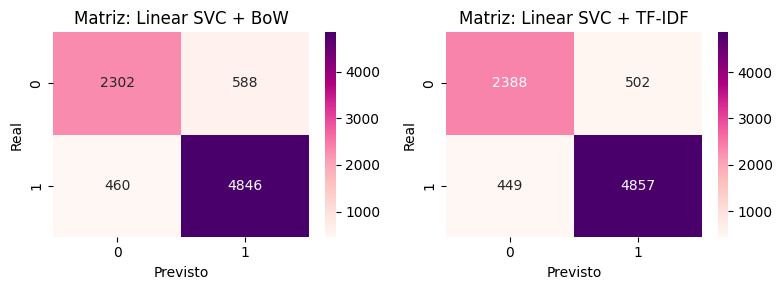

In [16]:
avaliar_modelo(LinearSVC(max_iter=2000), "Linear SVC", 
               X_train_bow, X_test_bow, 
               X_train_tfidf, X_test_tfidf, 
               y_train, y_test)

## 4.4 Random Forest Classifier
Um modelo de "Ensemble" que cria múltiplas árvores de decisão e combina seus resultados (votação). É menos sensível a outliers e consegue capturar interações não lineares entre os termos.

**Conclusão:**

O modelo Random Forest apresentou um desempenho consistente, mantendo uma acurácia estável de 88% em ambas as técnicas de vetorização. Diferente dos modelos lineares, este algoritmo baseado em árvores de decisão não apresentou ganho de acurácia ao mudar para o TF-IDF. O Bag of Words (BoW) destacou-se por apresentar o menor índice de Falsos Positivos (515), sendo ligeiramente mais preciso na identificação de críticas. Já o TF-IDF mostrou-se minimamente superior no reconhecimento de elogios, apresentando o menor índice de Falsos Negativos (471) entre as duas abordagens deste modelo.


===== Random Forest + BoW =====
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      2890
           1       0.90      0.91      0.91      5306

    accuracy                           0.88      8196
   macro avg       0.87      0.87      0.87      8196
weighted avg       0.88      0.88      0.88      8196


===== Random Forest + TF-IDF =====
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      2890
           1       0.90      0.91      0.91      5306

    accuracy                           0.88      8196
   macro avg       0.87      0.87      0.87      8196
weighted avg       0.88      0.88      0.88      8196



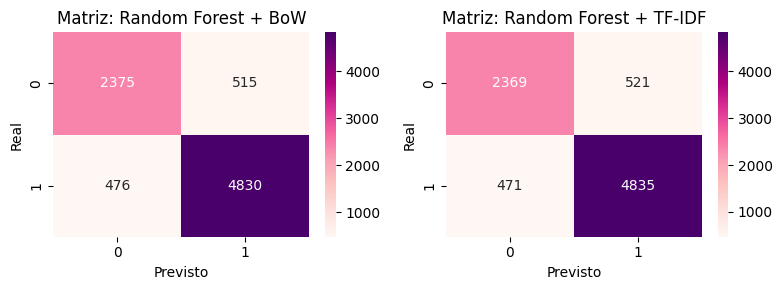

In [17]:
avaliar_modelo(RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42), "Random Forest", 
               X_train_bow, X_test_bow, 
               X_train_tfidf, X_test_tfidf, 
               y_train, y_test)

## 4.5 Stochastic Gradient Descent (SGDClassifier)
É uma técnica de otimização para treinar classificadores lineares (como SVM ou Regressão Logística). É focado em eficiência e escalabilidade, sendo ideal para grandes volumes de dados (Big Data).

**Conclusão:**

O modelo SGD Classifier atingiu uma acurácia sólida de 89%. Este algoritmo demonstrou alta consistência entre as vetorizações, mantendo métricas de precisão e recall equilibradas para ambas as classes. O Bag of Words (BoW) destacou-se por apresentar o menor índice de Falsos Negativos (389), sendo o mais eficiente em reconhecer corretamente os elogios dos clientes. Já o TF-IDF mostrou-se superior na redução de Falsos Positivos (427), sendo o método mais rigoroso na identificação de críticas negativas em toda a base de teste.


===== SGD Classifier + BoW =====
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      2890
           1       0.91      0.93      0.92      5306

    accuracy                           0.89      8196
   macro avg       0.88      0.88      0.88      8196
weighted avg       0.89      0.89      0.89      8196


===== SGD Classifier + TF-IDF =====
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2890
           1       0.92      0.92      0.92      5306

    accuracy                           0.89      8196
   macro avg       0.88      0.88      0.88      8196
weighted avg       0.89      0.89      0.89      8196



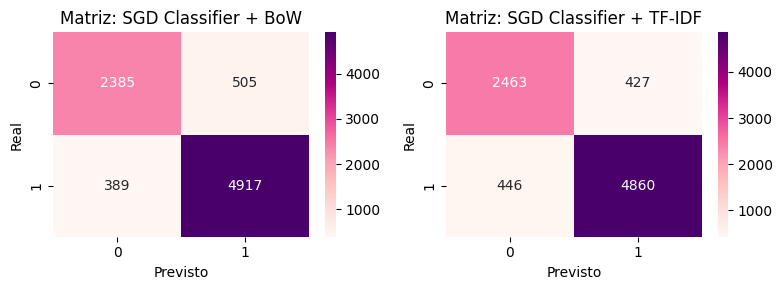

In [18]:
avaliar_modelo(SGDClassifier(random_state=42), "SGD Classifier", 
               X_train_bow, X_test_bow, 
               X_train_tfidf, X_test_tfidf, 
               y_train, y_test)

# 4.6 Ranking de Modelos

Nesta etapa, consolidamos o desempenho de todos os classificadores testados para identificar a combinação mais eficiente entre algoritmo e técnica de vetorização. A comparação utiliza a Acurácia como métrica de eficácia global e o F1-Score (Macro) para garantir que o modelo mantém um equilíbrio de performance entre as classes positiva e negativa, independentemente do volume de dados.

**Conclusão:** Os modelos alcançaram 89% de acurácia, com a Regressão Logística e o SGD Classifier consolidando-se como os vencedores na vetorização por Bag of Words. No cenário utilizando TF-IDF, o Naive Bayes juntou-se ao topo do ranking.

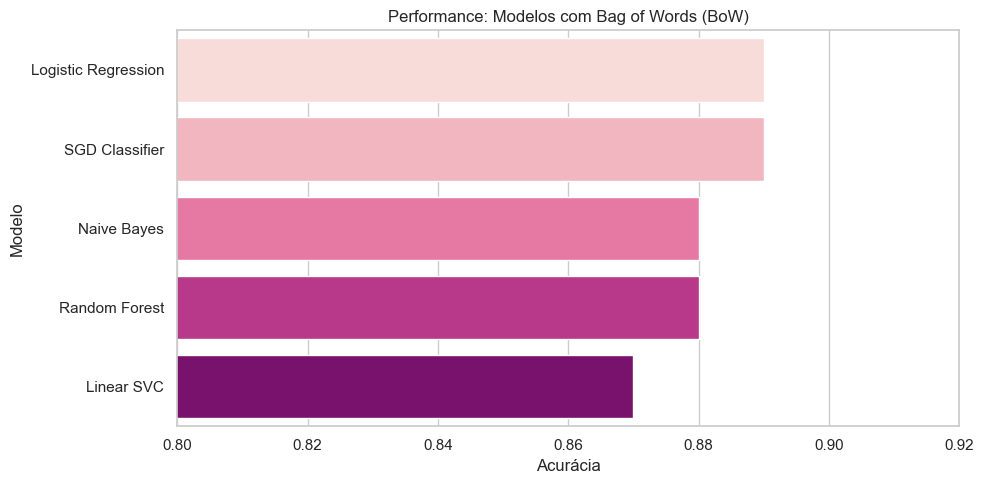

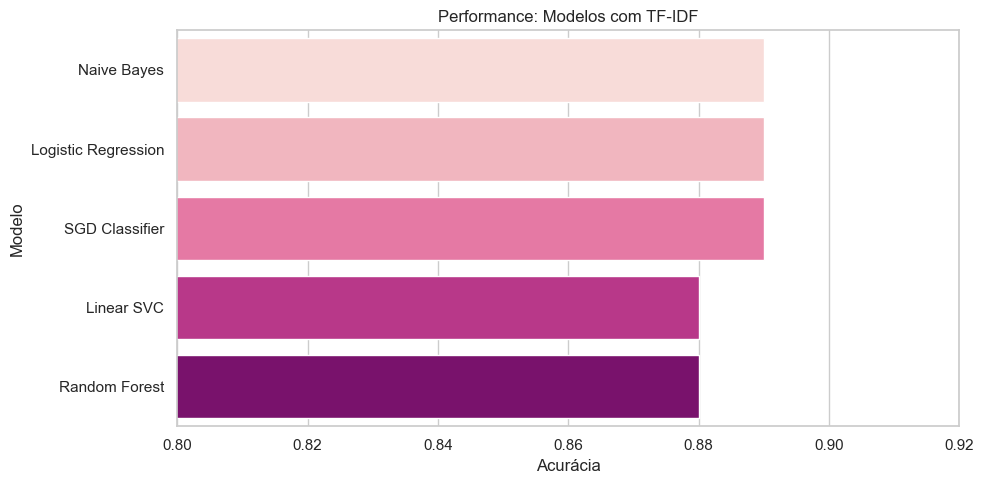

In [27]:
dados = [
    {'Modelo': 'Naive Bayes', 'Vetorização': 'BoW', 'Acurácia': 0.88},
    {'Modelo': 'Naive Bayes', 'Vetorização': 'TF-IDF', 'Acurácia': 0.89},
    {'Modelo': 'Logistic Regression', 'Vetorização': 'BoW', 'Acurácia': 0.89},
    {'Modelo': 'Logistic Regression', 'Vetorização': 'TF-IDF', 'Acurácia': 0.89},
    {'Modelo': 'Linear SVC', 'Vetorização': 'BoW', 'Acurácia': 0.87},
    {'Modelo': 'Linear SVC', 'Vetorização': 'TF-IDF', 'Acurácia': 0.88},
    {'Modelo': 'Random Forest', 'Vetorização': 'BoW', 'Acurácia': 0.88},
    {'Modelo': 'Random Forest', 'Vetorização': 'TF-IDF', 'Acurácia': 0.88},
    {'Modelo': 'SGD Classifier', 'Vetorização': 'BoW', 'Acurácia': 0.89},
    {'Modelo': 'SGD Classifier', 'Vetorização': 'TF-IDF', 'Acurácia': 0.89}
]

ranking_bow, ranking_tfidf = resultados(dados)

# 5. Visualização de Termos (Nuvem de Palavras)
Nesta etapa, geramos nuvens de palavras para identificar visualmente os termos mais frequentes em cada categoria de sentimento.

**Uso de Radicais (Stemming):**
As palavras aparecem em sua forma reduzida (ex: entreg, produt, compr).
- Vantagem: Agrupa diferentes variações de uma mesma palavra, focando no significado central.

**Análise Comparativa:**
- Nuvem Positiva: Destaca os motivos de satisfação (agilidade, qualidade).
- Nuvem Negativa: Evidencia os principais problemas (atrasos, defeitos).

**Conclusão:**
A nuvem de palavras destaca que radicais relacionados ao recebimento são muito frequentes em ambos os casos, o que pode significar que a qualidade da entrega é de grande influência.

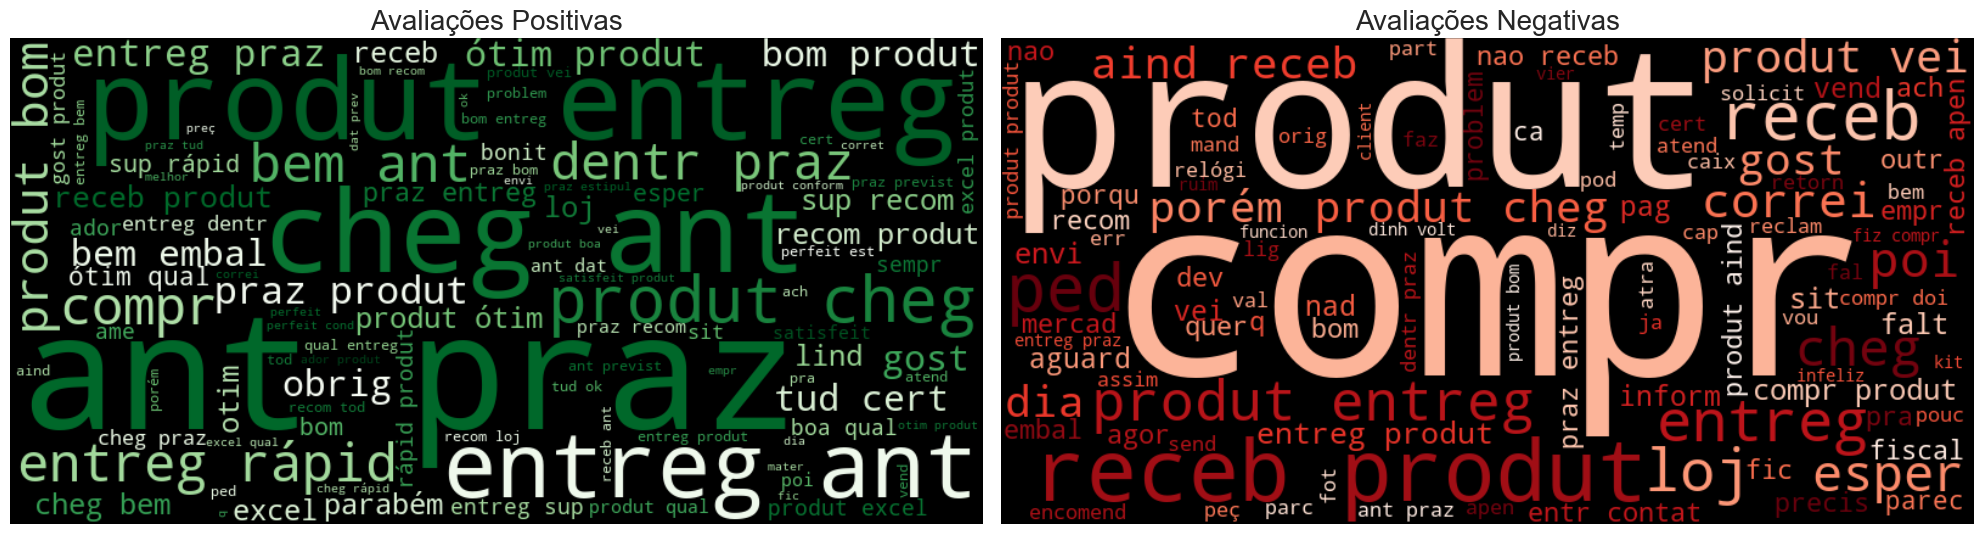

In [20]:
nuvens_palavras(df_nlp, 'review_comment_message', 'opinião')